1. Грузим агрегированные данные о поездках в мае 2016. Суммируем общее количество поездок такси из каждой географической зоны и считаем количество ячеек, из которых в мае не было совершено ни одной поездки.
2. Рисуем статическую карту Нью-Йорка с точкой там, где находится Эмпайр-Стейт-Билдинг.
3. Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.
4. Вставляем интерактивную карту Нью-Йорка с прокруткой и увеличением. Ставим метку там, где находится статуя свободы.
5. Рисуем на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок в час из этой зоны.
6. Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Считаем количество оставшихся. Проверяем на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.
7. Сохраните ноутбук в формате html, html облегчит задачу проверки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
import folium
import json
import geojson
from folium import plugins
import branca.colormap as cm
from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Загрузка данных и подсчёт

In [3]:
with open('data/regions_week1.pkl', 'rb') as reg_week_1:
    regions = pickle.load(reg_week_1)

In [4]:
ny_coordinates = [[ -74.25559, -73.70001],[40.91553, 40.49612]]
NY_west = ny_coordinates[0][0]
NY_east = ny_coordinates[0][1]
NY_north = ny_coordinates[1][0]
NY_south =  ny_coordinates[1][1]
ESB_long = -73.985664
ESB_lat  =  40.748441
SoL_lat = 40.6892776
SoL_long= -74.0445938

Общее количество поездок такси из каждой географической зоны

In [5]:
regions['sum_trips'] = regions[list(regions.iloc[:,5:])].sum(axis=1)
print(regions.sum_trips)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2495    0.0
2496    0.0
2497    0.0
2498    0.0
2499    0.0
Name: sum_trips, Length: 2500, dtype: float64


Количество ячеек с 0 поездок

In [6]:
print('Количество ячеек с 0 поездок:', sum(regions.sum_trips == 0))

Количество ячеек с 0 поездок: 1283


## 2. Статическая карта

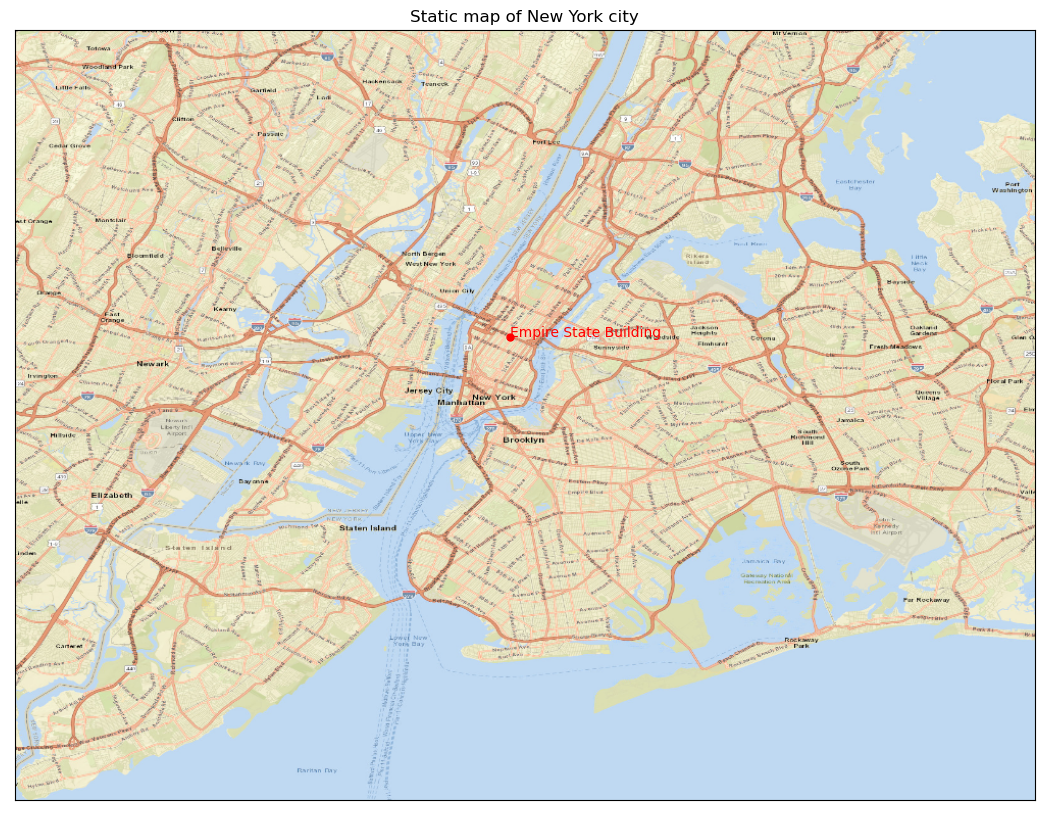

In [7]:
plt.figure(figsize=(15,10))

static_map = Basemap(llcrnrlat=NY_south, llcrnrlon=NY_west, 
                     urcrnrlat=NY_north, urcrnrlon=NY_east,
                     resolution='f',projection='lcc',
                     lat_0=(NY_north+NY_south)/2, 
                     lon_0=(NY_west+NY_east)/2, epsg=4326)

static_map.arcgisimage(service='World_Street_Map', xpixels=1000)

x,y = static_map(ESB_long, ESB_lat)
plt.plot(x,y, 'ok', markersize=5, color='red')
plt.text(x,y, 'Empire State Building', fontsize=10, color='red')
plt.title('Static map of New York city')
plt.show()
#plot_map(service='ESRI_StreetMap_World_2D')

## 3. Тепловая карта

In [8]:
vmax=regions.sum_trips.min(axis=0)
vmin=regions.sum_trips.max(axis=0)
summ = regions.sum_trips

In [9]:
heat_lon= np.unique(regions[['west','east']])
heat_lat=np.unique(regions[['north','south']])
lon, lat = np.meshgrid(heat_lon,heat_lat)

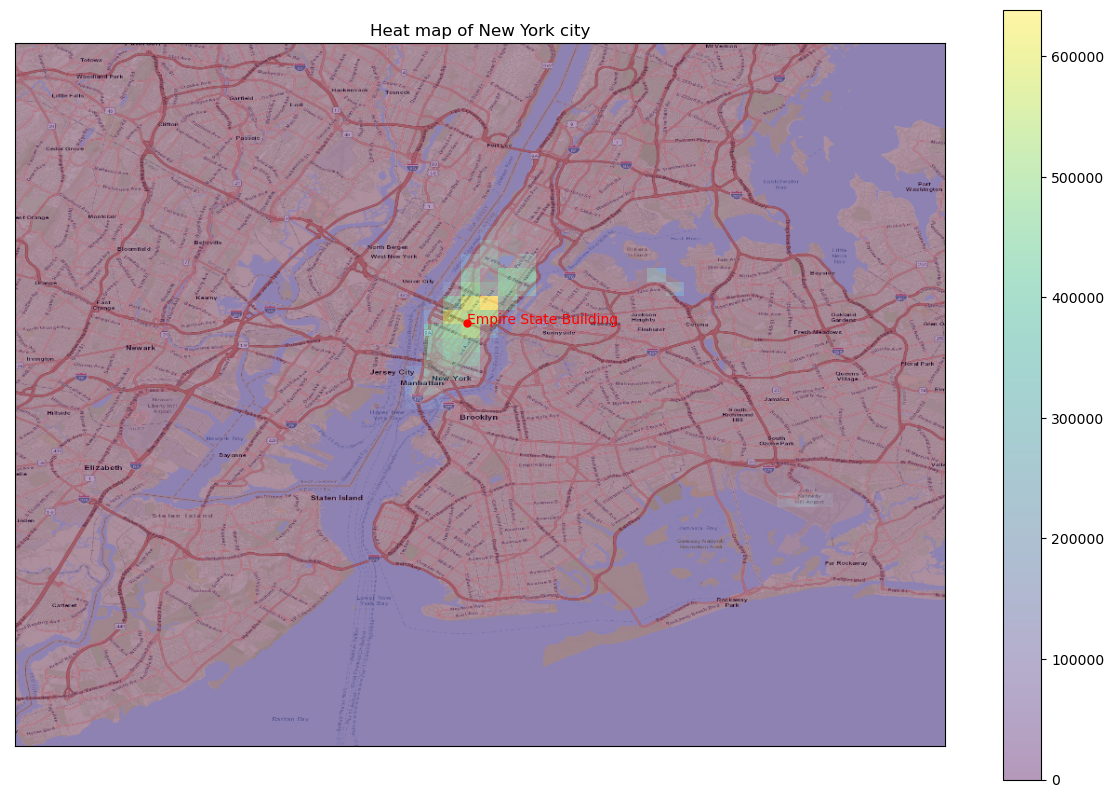

In [10]:
plt.figure(figsize=(15,10))

heat_map = Basemap(llcrnrlat=NY_south, llcrnrlon=NY_west, 
                     urcrnrlat=NY_north, urcrnrlon=NY_east,
                     resolution='f',projection='lcc',
                     lat_0=(NY_north+NY_south)/2, 
                     lon_0=(NY_west+NY_east)/2, epsg=4326)

heat_map.arcgisimage(service='World_Street_Map', xpixels=1000)
heat_map.pcolormesh(lon,lat,summ.values.reshape(50,50).transpose(),
                    vmax=vmax,
                    vmin=vmin,
                    alpha=0.4,latlon=True)
plt.colorbar()
x,y = heat_map(ESB_long, ESB_lat)
plt.plot(x,y, 'ok', markersize=5, color='red')
plt.text(x,y, 'Empire State Building', fontsize=10, color='red')
plt.title('Heat map of New York city')

#heat_map.scatter(regions.sum_trips, regions.region,s=1)
plt.show()

## 4. Интерактивная карта 

In [11]:
interactive_map = folium.Map(location=[(NY_north+NY_south)/2.,(NY_west+NY_east)/2.], 
                             titles='cartodbpositron', 
                             zoom_start=11,
                             control_scale=True)

folium.Marker(location=[SoL_lat,SoL_long], 
              popup='State of Liberty',
             icon=folium.Icon(color='green')).add_to(interactive_map)

interactive_map

## 5. Тепловая интерактивная карта

In [12]:
mean_trips = regions.sum_trips.values/len(regions.iloc[0,5:-1])
regions['mean_trips'] = mean_trips

In [13]:
# coordinate to json converter with multopilygon geojson
#https://gis.stackexchange.com/questions/220997/pandas-to-geojson-multiples-points-features-with-python
def data2geojson(df):
    features = []
    insert_features = lambda X: features.append(
        geojson.Feature(geometry = geojson.Polygon([[(X['west'], X['south']),
                                                     (X['east'], X['south']),
                                                     (X['east'], X['north']),
                                                     (X['west'], X['north'])]]),
                        id = str(X.name)))
    df.apply(insert_features, axis = 1)
    feature_collection = geojson.FeatureCollection(features)
    dumps = geojson.dumps(feature_collection)
    return geojson.loads(dumps)

In [14]:
geo_data_json = data2geojson(regions.iloc[:,1:5])

In [15]:
# coord = regions.iloc[:,0:5]
# coord.set_index('region',inplace=True)
# coord.apply(lambda x: x*pi/180.)
# geo_data_json = data2geojson(coord)

In [16]:
df = pd.DataFrame(regions.mean_trips.values,columns=['value'])
df['id']=regions.region.values

In [17]:
df.value.max()

858.6008064516129

In [18]:
interactive_heat_map = folium.Map(location=[(NY_north+NY_south)/2.,(NY_west+NY_east)/2.], 
                             titles='cartodbpositron', 
                             zoom_start=11,
                             control_scale=True)

folium.Marker(location=[SoL_lat,SoL_long], 
              popup='State of Liberty',
              icon=folium.Icon(color='green')).add_to(interactive_heat_map)

folium.Marker(location=[ESB_lat,ESB_long], 
              popup='Empire State Building',
              icon=folium.Icon()).add_to(interactive_heat_map)

folium.Choropleth(
    geo_data=geo_data_json,
    data=df.value,
    columns=['id','value'],
    key_on='id',
    fill_color = 'OrRd',
    legend_name = 'Mean trips on hours',
    nan_fill_opacity=0,
    fill_opacity=0.75,
    line_opacity=0.2).add_to(interactive_heat_map)

folium.LayerControl().add_to(interactive_heat_map)
interactive_heat_map

К сожалению, здесь явный баг folium. Ячейки считаны верно(если отдалить сетка видна отлично), средние значения тоже(по шкале видны минимум и максимум, что при проверке(df.value.max()) максимальные значения совпадает)

## Фильтрация ячеек

In [19]:
print('Количество ячеек с поездками больше 5:', (regions.mean_trips >= 5).sum())

Количество ячеек с поездками больше 5: 102


In [20]:
interactive_heat_map2 = folium.Map(location=[(NY_north+NY_south)/2.,(NY_west+NY_east)/2.], 
                             titles='cartodbpositron', 
                             zoom_start=11,
                             control_scale=True)
# folium.Marker(location=[SoL_lat,SoL_long], 
#               popup='State of Liberty',
#              icon=folium.Icon(color='green')).add_to(interactive_heat_map)
# folium.Marker(location=[ESB_lat,ESB_long], 
#               popup='Empire State Building',
#              icon=folium.Icon()).add_to(interactive_heat_map)

folium.Choropleth(
    geo_data=geo_data_json,
    data=df[df.value >= 5],
    columns=['id','value'],
    key_on='id',
    fill_color = 'OrRd',
    legend_name = 'Mean trips on hours more then 5',
    nan_fill_opacity=0,
    fill_opacity=0.7,
    line_opacity=0.2).add_to(interactive_heat_map2)

folium.LayerControl().add_to(interactive_heat_map2)
interactive_heat_map2

In [21]:
# import os
# os.system('jupyter nbconvert --to html taxi_week2.ipynb')

In [22]:
regions.mean_trips.max()

858.6008064516129

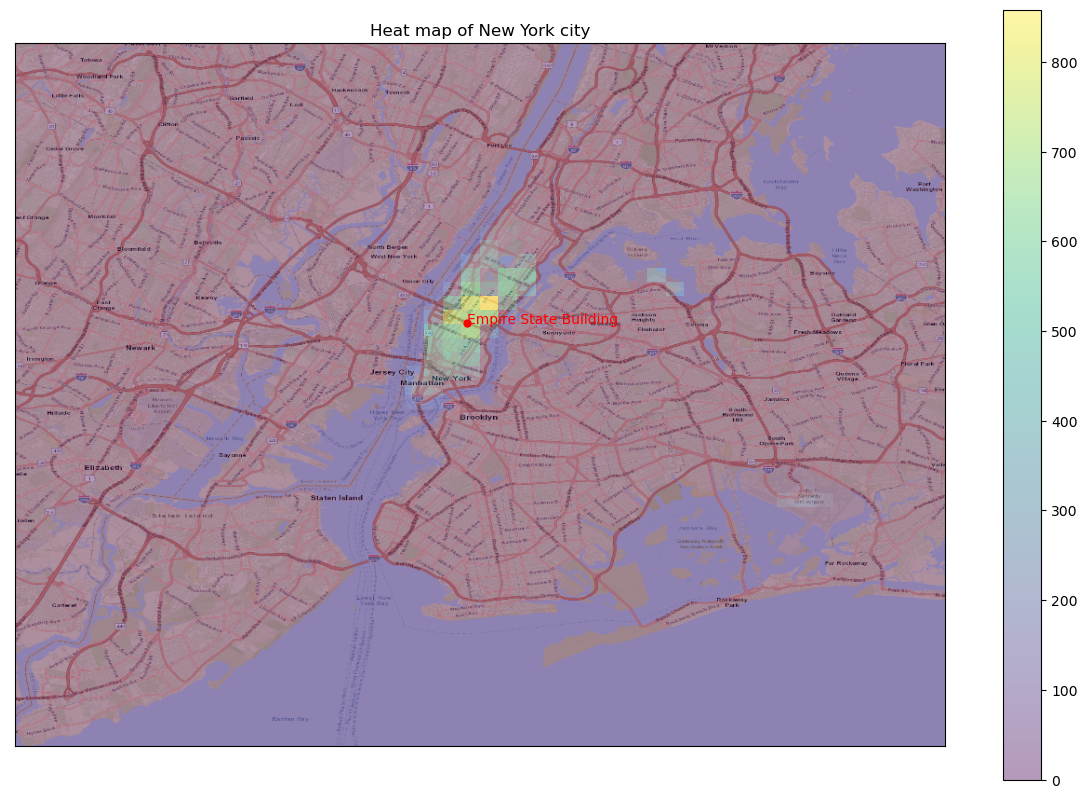

In [23]:
plt.figure(figsize=(15,10))

heat_map = Basemap(llcrnrlat=NY_south, llcrnrlon=NY_west, 
                   urcrnrlat=NY_north, urcrnrlon=NY_east,
                   resolution='f',
                   projection='lcc',
                   lat_0=(NY_north+NY_south)/2, 
                   lon_0=(NY_west+NY_east)/2, epsg=4326)

heat_map.arcgisimage(service='World_Street_Map', xpixels=1000)
heat_map.pcolormesh(lon,lat,df.value.values.reshape(50,50).transpose(),
                    vmax=regions.mean_trips.max(),
                    vmin=regions.mean_trips.min(),
                    alpha=0.4, 
                    latlon=True)
plt.colorbar()
x,y = heat_map(ESB_long, ESB_lat)
plt.plot(x,y, 'ok', markersize=5, color='red')
plt.text(x,y, 'Empire State Building', fontsize=10, color='red')
plt.title('Heat map of New York city')

#heat_map.scatter(regions.sum_trips, regions.region,s=1)
plt.show()

In [24]:
with open('regions_week2.pkl','wb') as fl:
    pickle.dump(regions, fl)